In [65]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# importing scripts
import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
from scripts import preprocessing_yellow

In [15]:
df = preprocessing_yellow.clean_yellow_taxi_df('../data', 2023, 1)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time_min,PU_Borough,DO_Borough
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,14.30,2.5,0.0,8.433333,Manhattan,Manhattan
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,0.5,4.00,0.0,1.0,16.90,2.5,0.0,6.316667,Manhattan,Manhattan
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,0.5,15.00,0.0,1.0,34.90,2.5,0.0,12.750000,Manhattan,Manhattan
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,0.5,3.28,0.0,1.0,19.68,2.5,0.0,10.833333,Manhattan,Manhattan
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,0.5,10.00,0.0,1.0,27.80,2.5,0.0,12.300000,Manhattan,Manhattan


# Data preparation

The data has already been processed and cleaned, and you can find additional details about the method used in the scripts/preprocessing_yellow.py file. The purpose of this notebook is to create a model that can accurately predict the number of trips in a specific area, enabling a company to allocate the appropriate number of drivers to those areas.

To begin, we will examine the data by grouping it at a high-level based on boroughs.

In [34]:
def sin_cos_transformation(df, column, period):
    value = 2*np.pi*df[column]/period
    features = {
        f'sin_{column}': lambda x: np.sin(value),
        f'cos_{column}': lambda x: np.cos(value),
    }
    return df.assign(**features)

df_grouped = (
    df
    # counting number of trips per hour in each district
    .groupby([
        pd.Grouper(key='tpep_pickup_datetime', axis=0, freq='H'), 
        'PU_Borough',
    ]) 
    .size().reset_index().rename(columns={0: 'num_of_trips'})
    # feature engineering, adding columns that represent the cyclic behaviour of hours and days of week
    .assign(
        hour=lambda x: x['tpep_pickup_datetime'].dt.hour,
        day_of_week=lambda x: x['tpep_pickup_datetime'].dt.day_of_week,
    )
    .pipe(sin_cos_transformation, column='hour', period=24)
    .pipe(sin_cos_transformation, column='day_of_week', period=7)
)
df_grouped

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
0,2023-01-01 00:00:00,Bronx,3,0,6,0.000000,1.000000,-0.781831,0.62349
1,2023-01-01 00:00:00,Brooklyn,37,0,6,0.000000,1.000000,-0.781831,0.62349
2,2023-01-01 00:00:00,EWR,0,0,6,0.000000,1.000000,-0.781831,0.62349
3,2023-01-01 00:00:00,Manhattan,4444,0,6,0.000000,1.000000,-0.781831,0.62349
4,2023-01-01 00:00:00,Queens,262,0,6,0.000000,1.000000,-0.781831,0.62349
...,...,...,...,...,...,...,...,...,...
4459,2023-01-31 23:00:00,Brooklyn,12,23,1,-0.258819,0.965926,0.781831,0.62349
4460,2023-01-31 23:00:00,EWR,0,23,1,-0.258819,0.965926,0.781831,0.62349
4461,2023-01-31 23:00:00,Manhattan,2084,23,1,-0.258819,0.965926,0.781831,0.62349
4462,2023-01-31 23:00:00,Queens,260,23,1,-0.258819,0.965926,0.781831,0.62349


# Exploration to see if there are any problems with data

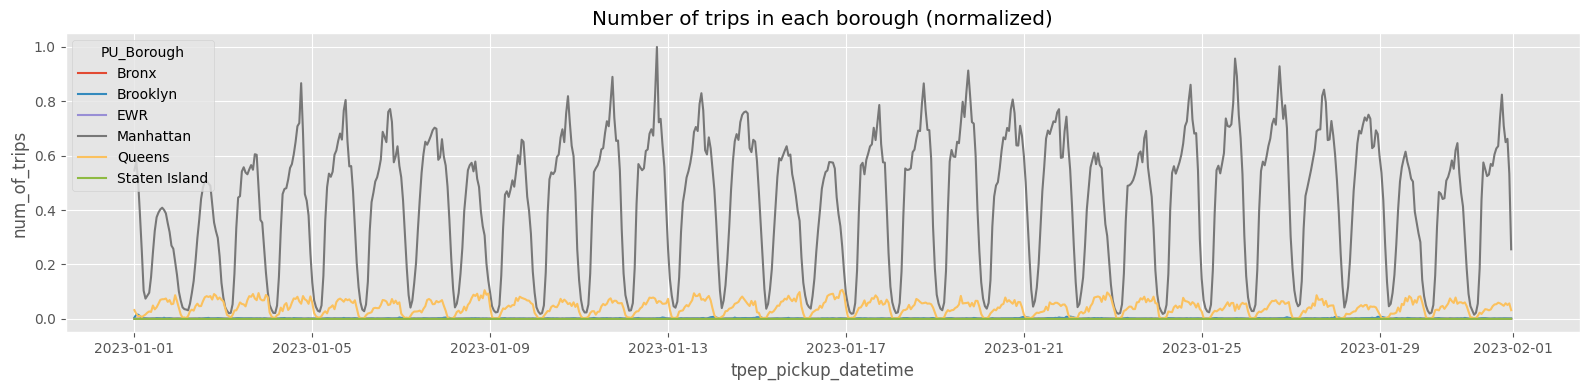

In [64]:
transformers = ColumnTransformer([
    ('pass', 'passthrough', ['tpep_pickup_datetime', 'PU_Borough']),
    ('min_max_scaling', MinMaxScaler(), ['num_of_trips']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

pipe = Pipeline([
    ('transformers', transformers)
])


fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.lineplot(pipe.fit_transform(df_grouped), x='tpep_pickup_datetime', y='num_of_trips', hue='PU_Borough', ax=ax)
ax.set_title('Number of trips in each borough (normalized)')
fig.tight_layout()

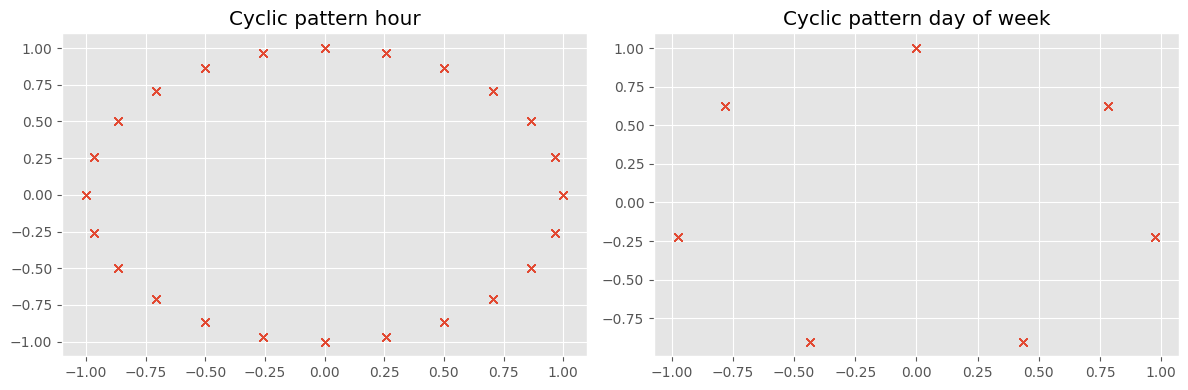

In [52]:
fig, ax = plt.subplots(1, 2,  figsize=(12, 4))
ax[0].plot(df_grouped['sin_hour'], df_grouped['cos_hour'], 'x'), ax[1].plot(df_grouped['sin_day_of_week'], df_grouped['cos_day_of_week'], 'x')
ax[0].set_title('Cyclic pattern hour'), ax[1].set_title('Cyclic pattern day of week')
fig.tight_layout()

- Number of trips for other districs than Manhattan and Queens is almost always a zero value. Since the other areas are not the main operating areas of Yellow taxis (there are Green taxi area) I will for now drop them as it will break the predictive performance of models.
- Cyclic patterns work as expected

I will utilize the following split to create separate training and testing datasets for modeling, based on the pickup date:

- Training dataset: It will consist of data from days 1 to 21.
- Testing dataset: It will include data from days 22 to 31.

In [68]:
# limiting data to only two districts
df_grouped = df_grouped[df_grouped['PU_Borough'].isin(['Manhattan', 'Queens'])]
# split condition
condition = df_grouped['tpep_pickup_datetime'] < '2023-01-22'
df_train, df_test = df_grouped[condition], df_grouped[~condition]
display(df_train.head(4), df_test.head(4), )

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
3,2023-01-01 00:00:00,Manhattan,4444,0,6,0.000000,1.000000,-0.781831,0.62349
4,2023-01-01 00:00:00,Queens,262,0,6,0.000000,1.000000,-0.781831,0.62349
9,2023-01-01 01:00:00,Manhattan,4722,1,6,0.258819,0.965926,-0.781831,0.62349
10,2023-01-01 01:00:00,Queens,153,1,6,0.258819,0.965926,-0.781831,0.62349


,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
3027,2023-01-22 00:00:00,Manhattan,5164,0,6,0.000000,1.000000,-0.781831,0.62349
3028,2023-01-22 00:00:00,Queens,124,0,6,0.000000,1.000000,-0.781831,0.62349
3033,2023-01-22 01:00:00,Manhattan,4479,1,6,0.258819,0.965926,-0.781831,0.62349
3034,2023-01-22 01:00:00,Queens,18,1,6,0.258819,0.965926,-0.781831,0.62349


<Axes: xlabel='sin_hour', ylabel='num_of_trips'>

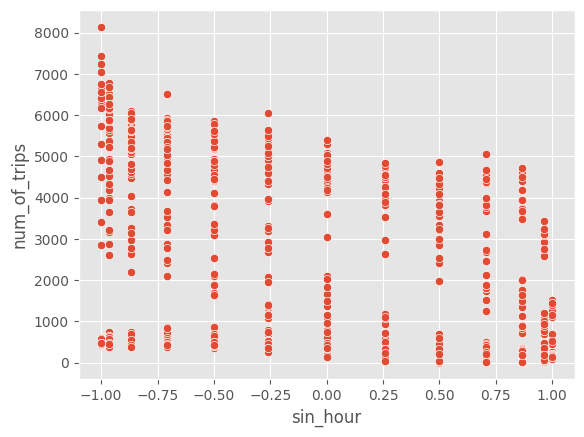

In [70]:
sns.scatterplot(df_train,  x='sin_hour', y='num_of_trips',)

# Linear regression